<a href="https://colab.research.google.com/github/Papa-Panda/Paper_reading/blob/main/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# generated by https://gemini.google.com/app/090227b96a8ccfd9

# inspired by Su Jianlin's series: https://link.zhihu.com/?target=https%3A//spaces.ac.cn/archives/9119

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.8MB/s]


Starting training...


Epoch 1/25: 100%|██████████| 468/468 [00:22<00:00, 21.21it/s, loss=0.1069]


Epoch 1 finished. Average Loss: 0.1778


Epoch 2/25: 100%|██████████| 468/468 [00:22<00:00, 21.11it/s, loss=0.0952]


Epoch 2 finished. Average Loss: 0.1083


Epoch 3/25: 100%|██████████| 468/468 [00:20<00:00, 23.16it/s, loss=0.0801]


Epoch 3 finished. Average Loss: 0.0888


Epoch 4/25: 100%|██████████| 468/468 [00:20<00:00, 22.94it/s, loss=0.0566]


Epoch 4 finished. Average Loss: 0.0802


Epoch 5/25: 100%|██████████| 468/468 [00:20<00:00, 22.99it/s, loss=0.0769]


Epoch 5 finished. Average Loss: 0.0746
Sampling images at epoch 5...


Sampling loop: 100%|██████████| 1000/1000 [00:02<00:00, 411.31it/s]


Saved sampled images to ddpm_samples/ddpm_sample_epoch_5.png


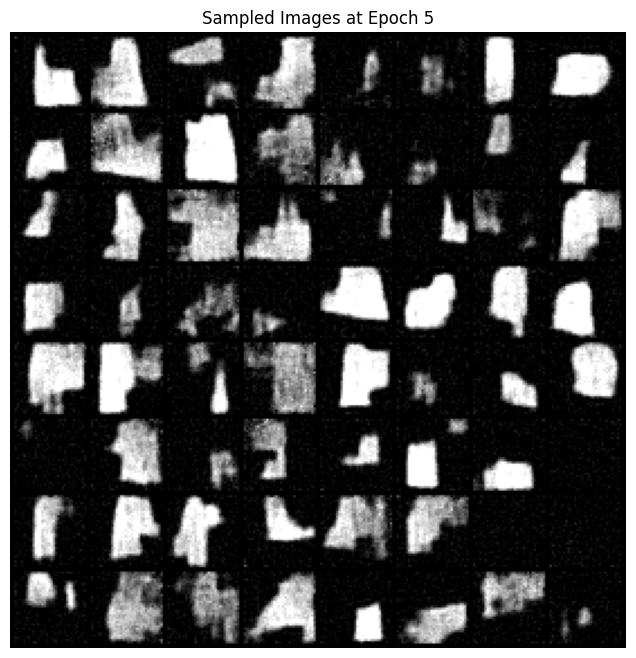

Epoch 6/25: 100%|██████████| 468/468 [00:22<00:00, 21.22it/s, loss=0.0608]


Epoch 6 finished. Average Loss: 0.0662


Epoch 7/25: 100%|██████████| 468/468 [00:22<00:00, 21.16it/s, loss=0.0626]


Epoch 7 finished. Average Loss: 0.0633


Epoch 8/25: 100%|██████████| 468/468 [00:21<00:00, 21.52it/s, loss=0.0707]


Epoch 8 finished. Average Loss: 0.0606


Epoch 9/25: 100%|██████████| 468/468 [00:22<00:00, 21.03it/s, loss=0.0910]


Epoch 9 finished. Average Loss: 0.0579


Epoch 10/25: 100%|██████████| 468/468 [00:22<00:00, 21.15it/s, loss=0.0689]


Epoch 10 finished. Average Loss: 0.0571
Sampling images at epoch 10...


Sampling loop: 100%|██████████| 1000/1000 [00:02<00:00, 431.14it/s]


Saved sampled images to ddpm_samples/ddpm_sample_epoch_10.png


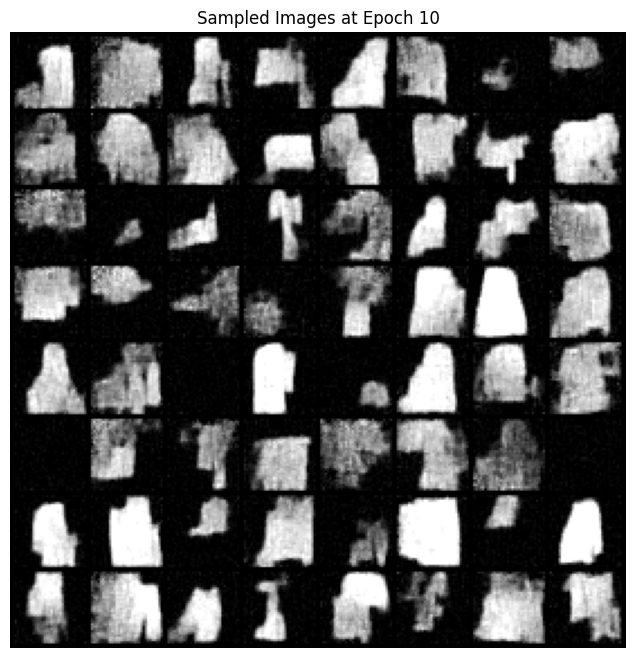

Epoch 11/25:  61%|██████▏   | 287/468 [00:14<00:08, 20.23it/s, loss=0.0411]

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# --- Configuration and Hyperparameters ---
class Config:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 128
    EPOCHS = 25  # Increased epochs for better results
    LR = 3e-4
    TIMESTEPS = 1000  # Number of steps in the diffusion process
    IMG_SIZE = 32  # Resize images to 32x32 for faster training

    # Create a directory to save sampled images
    OUTPUT_DIR = "ddpm_samples"
    os.makedirs(OUTPUT_DIR, exist_ok=True)

cfg = Config()

# --- 1. Data Loading ---
# We normalize images to the range [-1, 1], which is a common practice for diffusion models
transform = transforms.Compose([
    transforms.Resize((cfg.IMG_SIZE, cfg.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, drop_last=True)

# --- 2. Diffusion Scheduler (The "Forward Process") ---
# The forward process gradually adds noise to an image according to a variance schedule.
# This part is fixed and does not involve any learnable parameters.

def get_linear_schedule(timesteps):
    """
    Creates a linear variance schedule for the diffusion process.
    beta_t determines how much noise is added at timestep t.
    """
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps, device=cfg.DEVICE)

betas = get_linear_schedule(cfg.TIMESTEPS)
alphas = 1. - betas
alphas_hat = torch.cumprod(alphas, dim=0) # Cumulative product: α_hat_t = Π_{i=1 to t} α_i

# Pre-calculate values needed for the forward process formula
sqrt_alphas_hat = torch.sqrt(alphas_hat)
sqrt_one_minus_alphas_hat = torch.sqrt(1. - alphas_hat)

def forward_diffusion(x0, t):
    """
    Takes a batch of clean images (x0) and a batch of timesteps (t),
    and returns the corresponding noised images (xt) and the noise that was added.

    Formula: xt = sqrt(α_hat_t) * x0 + sqrt(1 - α_hat_t) * ε
    where ε is random noise.
    """
    # Sample random noise from a standard normal distribution
    noise = torch.randn_like(x0)

    # Get the sqrt(alpha_hat) and sqrt(1 - alpha_hat) values for the given timesteps
    # .gather() selects the values from the tensors at the indices specified by t
    # .reshape() is used to make the tensors broadcastable with the image batch
    sqrt_alphas_hat_t = sqrt_alphas_hat.gather(-1, t).reshape(cfg.BATCH_SIZE, 1, 1, 1)
    sqrt_one_minus_alphas_hat_t = sqrt_one_minus_alphas_hat.gather(-1, t).reshape(cfg.BATCH_SIZE, 1, 1, 1)

    # Apply the forward process formula to get the noised image
    xt = sqrt_alphas_hat_t * x0 + sqrt_one_minus_alphas_hat_t * noise
    return xt, noise

# --- 3. The Model (A Simple U-Net for Noise Prediction) ---
# The model's job is to look at a noisy image xt and predict the noise (ε)
# that was added to the original image x0 at timestep t.
# A U-Net architecture is well-suited for this task.

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Simplified U-Net structure. A real implementation would use time embeddings and attention.
        self.down1 = nn.Conv2d(1, 32, 3, padding=1)
        self.down2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = nn.Conv2d(64, 128, 3, padding=1)

        self.up_conv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up1 = nn.Conv2d(128, 64, 3, padding=1) # Note: input channels = 64 (from up_conv) + 64 (from skip)
        self.up_conv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.up2 = nn.Conv2d(64, 32, 3, padding=1)  # Note: input channels = 32 (from up_conv) + 32 (from skip)

        self.out = nn.Conv2d(32, 1, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Encoder Path
        d1 = self.relu(self.down1(x))
        p1 = self.pool(d1)
        d2 = self.relu(self.down2(p1))
        p2 = self.pool(d2)

        # Bottleneck
        b = self.relu(self.bottleneck(p2))

        # Decoder Path with Skip Connections
        u1 = self.up_conv1(b)
        # The skip connection concatenates the output from the corresponding encoder layer
        skip1 = torch.cat([u1, d2], dim=1)
        u1_out = self.relu(self.up1(skip1))

        u2 = self.up_conv2(u1_out)
        skip2 = torch.cat([u2, d1], dim=1)
        u2_out = self.relu(self.up2(skip2))

        return self.out(u2_out)

# --- 4. The Training Loop ---
model = SimpleUNet().to(cfg.DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.LR)
criterion = nn.MSELoss() # The paper uses L1 or L2 loss. MSE (L2) is common.

print("Starting training...")
for epoch in range(cfg.EPOCHS):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{cfg.EPOCHS}")
    total_loss = 0
    for step, (images, _) in enumerate(pbar):
        optimizer.zero_grad()

        x0 = images.to(cfg.DEVICE)

        # 1. Sample random timesteps `t` for each image in the batch
        t = torch.randint(0, cfg.TIMESTEPS, (cfg.BATCH_SIZE,), device=cfg.DEVICE).long()

        # 2. Create noisy images `xt` using the forward process and get the added noise
        xt, real_noise = forward_diffusion(x0, t)

        # 3. The model predicts the noise from the noised image
        predicted_noise = model(xt)

        # 4. Calculate the loss between the real noise and the predicted noise
        loss = criterion(real_noise, predicted_noise)

        # 5. Backpropagate and update model weights
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} finished. Average Loss: {avg_loss:.4f}")

    # --- 5. Sampling (The "Reverse Process") after each epoch ---
    if (epoch + 1) % 5 == 0: # Sample every 5 epochs
        print(f"Sampling images at epoch {epoch+1}...")
        model.eval()
        with torch.no_grad():
            # Start with pure random noise (this is x_T)
            img = torch.randn((64, 1, cfg.IMG_SIZE, cfg.IMG_SIZE), device=cfg.DEVICE)

            # Loop backwards from T-1 down to 0
            for i in tqdm(reversed(range(cfg.TIMESTEPS)), desc="Sampling loop", total=cfg.TIMESTEPS):
                t = torch.full((64,), i, device=cfg.DEVICE, dtype=torch.long)

                predicted_noise = model(img)

                # Get pre-calculated values for the current timestep
                alpha_t = alphas[t][:, None, None, None]
                alpha_hat_t = alphas_hat[t][:, None, None, None]
                beta_t = betas[t][:, None, None, None]

                # The core of the reverse process step
                # 1. Calculate the mean of the distribution for x_{t-1}
                term1 = 1 / torch.sqrt(alpha_t)
                term2 = (1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)
                mean = term1 * (img - term2 * predicted_noise)

                # 2. Add noise (variance) to get the final x_{t-1}
                if i != 0:
                    noise = torch.randn_like(img)
                    variance = torch.sqrt(beta_t) * noise
                    img = mean + variance
                else: # No noise at the last step
                    img = mean

        model.train()
        # Denormalize from [-1, 1] to [0, 1] and clamp
        img = (img.clamp(-1, 1) + 1) / 2

        # Save a grid of the generated images
        grid = make_grid(img, nrow=8)
        save_path = os.path.join(cfg.OUTPUT_DIR, f"ddpm_sample_epoch_{epoch+1}.png")
        save_image(grid, save_path)
        print(f"Saved sampled images to {save_path}")

        # --- Plot the generated images ---
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title(f"Sampled Images at Epoch {epoch+1}")
        # We need to permute the tensor dimensions from (C, H, W) to (H, W, C) for matplotlib
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.show()

print("Training finished.")

In [1]:
1

1